![logo](images/seamcast%20light%20small.png)

# SeamCast Movie Recommendation System
Author: Ian Musau<hr>

## Overview
SeamCast is a planned movie streaming service that will also allow separate users to strem the same film in sync. They are in need of a robust movie recommendation system that users can enjoy together. As the service is not up and running yet, data from Netflix has been sourced from the web as a means to create the recommendation algorithm.<br>
Recommendations will be done by clustering similar users together and recommending movies popular with similar users.

## Business Problem
Given that the system is not only astreming platform, but will also allow multiple users to stream the same film concurrently to watch together, SeamCast is in need of a system that will:
- Find the best suited movies for a given user
- Recommend movies that will be njoyed by all parties in the group
- Identify different subsets of users and cater to their tastes

## Setup

#### Importing necessary libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline

import combined_data
from dataframeWrapper import DataFrameWrapper

%matplotlib inline


## Data Understanding
The analysis makes use of two datasets from Netflix. One contains user ratings of movies and the other contains movie characteristics such as runtime and genres.

### Loading movie titles

In [46]:
columns = [0,1,2]
movies = pd.read_csv(
    "netflix-data/movie_titles.csv",
    encoding="ISO-8859-1",
    usecols=columns
)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


Only 7 titles have missing data so they are dropped and years converted to int values

In [47]:
movies.dropna(inplace=True)
movies.Year = movies.Year.astype(int)
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


## Data Preparation

Merging genre and runtime information found in another dataset

In [48]:
movie_info = pd.read_csv("data/movie_basics.csv")
movie_info.drop(
    ["movie_id", "original_title"],
    axis=1, inplace=True
)
movie_info.rename(columns={"primary_title" : "title"}, inplace=True)
movie_info.rename(columns={"start_year" : "year"}, inplace=True)
movie_info.rename(columns={"runtime_minutes" : "runtime"}, inplace=True)
movie_info.drop_duplicates(subset="title", keep="first", inplace=True)

movie_info

,title,year,runtime,genres
0,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,The Other Side of the Wind,2018,122.0,Drama
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,Dankyavar Danka,2013,NaN,Comedy
146142,6 Gunn,2017,116.0,NaN


In [49]:
movie_info.duplicated().sum()

0

Dropping duplicate variables and columns

In [50]:
movies = pd.merge(movies, movie_info, left_on="Title", right_on="title")
movies.drop("Title", axis=1, inplace=True)
movies.drop("year", axis=1, inplace=True)

movies

,ID,Year,title,runtime,genres
0,6,1997,Sick,99.0,"Comedy,Drama"
1,10,2001,Fighter,NaN,"Drama,Sport"
2,45,1999,The Love Letter,12.0,"Adventure,Documentary"
3,17721,1998,The Love Letter,12.0,"Adventure,Documentary"
4,48,2001,Justice League,120.0,"Action,Adventure,Fantasy"
...,...,...,...,...,...
2118,17749,1985,No End,NaN,"Horror,Thriller"
2119,17752,2003,Out of Order,67.0,Comedy
2120,17754,1999,On the Ropes,94.0,Comedy
2121,17758,1979,Prophecy,119.0,Mystery


Dealing with missing data

In [51]:
movies.isna().sum()

ID           0
Year         0
title        0
runtime    435
genres      65
dtype: int64

In [52]:
movies.runtime.fillna(movies.runtime.median(), inplace=True)
movies.genres.fillna("Unknown", inplace=True)

In [53]:
movies.isna().sum()

ID         0
Year       0
title      0
runtime    0
genres     0
dtype: int64

In [54]:
movies

,ID,Year,title,runtime,genres
0,6,1997,Sick,99.0,"Comedy,Drama"
1,10,2001,Fighter,91.0,"Drama,Sport"
2,45,1999,The Love Letter,12.0,"Adventure,Documentary"
3,17721,1998,The Love Letter,12.0,"Adventure,Documentary"
4,48,2001,Justice League,120.0,"Action,Adventure,Fantasy"
...,...,...,...,...,...
2118,17749,1985,No End,91.0,"Horror,Thriller"
2119,17752,2003,Out of Order,67.0,Comedy
2120,17754,1999,On the Ropes,94.0,Comedy
2121,17758,1979,Prophecy,119.0,Mystery


### Examining the ratings dataset

Converting `combined_data_n.txt` files into feather format if necessary and loading them for analysis. (Functions defined in `combined_data.py`) 

In [55]:
dev_dataset_rows = 500000 #number of records to use for the analysis
combined_data.initialize_all_data()
ratings = pd.read_feather(combined_data.combined_ratings_path())
ratings = ratings.head(dev_dataset_rows)
ratings

,movie,user,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3
...,...,...,...
499995,148,178520,3
499996,148,1257939,5
499997,148,1700782,2
499998,148,380354,1


In [56]:
ratings = pd.merge(ratings, movies, how="inner", left_on="movie", right_on="ID")
ratings.drop(["ID", "title"], axis=1, inplace=True)
ratings

,movie,user,rating,Year,runtime,genres
0,6,2031561,1,1997,99.0,"Comedy,Drama"
1,6,1176140,1,1997,99.0,"Comedy,Drama"
2,6,2336133,2,1997,99.0,"Comedy,Drama"
3,6,1521836,1,1997,99.0,"Comedy,Drama"
4,6,117277,3,1997,99.0,"Comedy,Drama"
...,...,...,...,...,...,...
58342,143,923388,5,1997,91.0,Horror
58343,143,87898,4,1997,91.0,Horror
58344,143,694704,4,1997,91.0,Horror
58345,143,1704768,4,1997,91.0,Horror


In [57]:
ratings.dtypes

movie        int64
user         int64
rating       int64
Year         int64
runtime    float64
genres      object
dtype: object

In [58]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58347 entries, 0 to 58346
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movie    58347 non-null  int64  
 1   user     58347 non-null  int64  
 2   rating   58347 non-null  int64  
 3   Year     58347 non-null  int64  
 4   runtime  58347 non-null  float64
 5   genres   58347 non-null  object 
dtypes: float64(1), int64(4), object(1)
memory usage: 2.7+ MB


The dataset has no missing values

In [59]:
ratings.isna().sum()

movie      0
user       0
rating     0
Year       0
runtime    0
genres     0
dtype: int64

Dataframe shape

In [60]:
ratings.shape

(58347, 6)

No duplicate ratings in the dataset

In [61]:
ratings.duplicated().any()

False

## Exploratory Data Analysis

### Ratings bar plot

In [62]:
ratings_count = ratings.rating.value_counts()
ratings_count

rating
4    22168
3    16373
5    12685
2     5132
1     1989
Name: count, dtype: int64

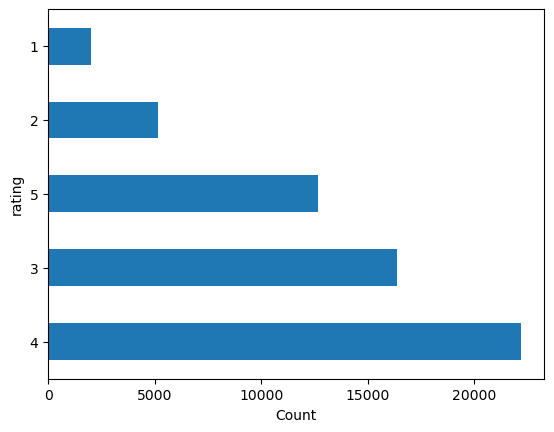

In [63]:
ratings_count.plot(kind="barh", xlabel="Count");

#### Observation

The vast majority of films are rated favorably or neutral

### Ratings box plot

In [64]:
ratings.rating.median()

4.0

In [65]:
q1 = np.percentile(ratings.rating, 25)
q3 = np.percentile(ratings.rating, 75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3:{q3}\nInterquartile Range:{iqr}")

Q1: 3.0
Q3:4.0
Interquartile Range:1.0


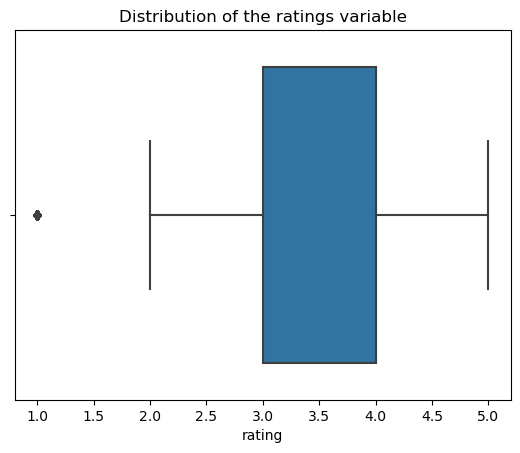

In [66]:
sns.boxplot(x='rating', data=ratings)
plt.title("Distribution of the ratings variable");

#### Observations
- The ratings have a median of 4 and an IQR of 1
- There appears to be outliers at the lower end of the ratings which might indicate class imbalance

### Reducing rating categories (Negative: 0, Positive: 1)

In [67]:
ratings["category"] = ratings.rating.apply(
    lambda x:
        0 if x <= 3
        else(1 )
)
ratings.head()

,movie,user,rating,Year,runtime,genres,category
0,6,2031561,1,1997,99.0,"Comedy,Drama",0
1,6,1176140,1,1997,99.0,"Comedy,Drama",0
2,6,2336133,2,1997,99.0,"Comedy,Drama",0
3,6,1521836,1,1997,99.0,"Comedy,Drama",0
4,6,117277,3,1997,99.0,"Comedy,Drama",0


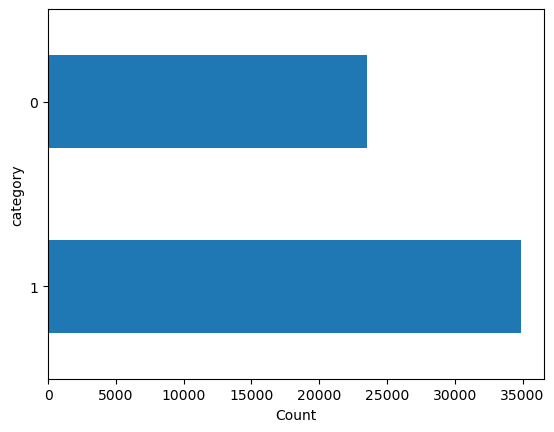

In [68]:
ratings_count = ratings.category.value_counts()
ratings_count.plot(kind="barh", xlabel="Count");

#### Observations
- Ther's a more even split between classes now

With our rating categories set, we can drop the original rating column

In [69]:
ratings.drop("rating", axis=1, inplace=True)
ratings

,movie,user,Year,runtime,genres,category
0,6,2031561,1997,99.0,"Comedy,Drama",0
1,6,1176140,1997,99.0,"Comedy,Drama",0
2,6,2336133,1997,99.0,"Comedy,Drama",0
3,6,1521836,1997,99.0,"Comedy,Drama",0
4,6,117277,1997,99.0,"Comedy,Drama",0
...,...,...,...,...,...,...
58342,143,923388,1997,91.0,Horror,1
58343,143,87898,1997,91.0,Horror,1
58344,143,694704,1997,91.0,Horror,1
58345,143,1704768,1997,91.0,Horror,1


### Heatmap

In [70]:
ratings_corr =  ratings.drop("genres", axis=1).corr()
ratings_corr

,movie,user,Year,runtime,category
movie,1.000000,-0.003529,-0.065909,0.087256,0.192515
user,-0.003529,1.000000,-0.000377,-0.004538,-0.004364
Year,-0.065909,-0.000377,1.000000,-0.075944,0.064392
runtime,0.087256,-0.004538,-0.075944,1.000000,0.080107
category,0.192515,-0.004364,0.064392,0.080107,1.000000


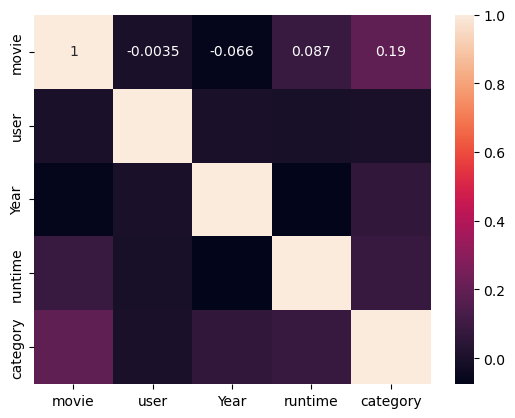

In [71]:
sns.heatmap(ratings_corr, annot=True);

#### Observations
There appears to be no strong correlation between any of the variables, indicating a non-linear more complex relationship.<hr>

## Modeling

The genre feature is encoded. As some movies belong to more than one genre, a MultiLabelBinarizer is used

In [72]:
mlb = MultiLabelBinarizer()
#function to splt genre strin into a list of genre strings and encode them
def genres_ohe(df):
    df['genres'] = df['genres'].str.split(',')
    one_hot_encoded = mlb.fit_transform(df['genres'])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    return one_hot_encoded_df

In [73]:
ratings = pd.concat([ratings, genres_ohe(ratings)], axis=1)
ratings.drop("genres", axis=1, inplace=True)

ratings

,movie,user,Year,runtime,category,Action,Adventure,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sport,Thriller,War
0,6,2031561,1997,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,6,1176140,1997,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,6,2336133,1997,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,6,1521836,1997,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,6,117277,1997,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58342,143,923388,1997,91.0,1,0,0,0,0,0,0,0,1,0,0,0,0
58343,143,87898,1997,91.0,1,0,0,0,0,0,0,0,1,0,0,0,0
58344,143,694704,1997,91.0,1,0,0,0,0,0,0,0,1,0,0,0,0
58345,143,1704768,1997,91.0,1,0,0,0,0,0,0,0,1,0,0,0,0


### Base Model

A basic decision tree with default parameters is created

In [74]:
y = ratings.category
X = ratings.drop("category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [75]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_preds) * 100, 2)}%")

Accuracy: 56.32%


With our baeline model set, we endavour to improve it

### Hyperparameter Tuning

In [76]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 6, 7],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [5, 6, 7],
    'max_features': [None],
}
clf_grid = DecisionTreeClassifier()
grid = GridSearchCV(estimator=clf_grid, param_grid=param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best Parameters:", best_params)


# Get the best estimator
best_estimator = grid.best_estimator_
y_preds_grid = best_estimator.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_preds_grid) :.2%}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy: 66.80%


In [77]:
tuned_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2)
tuned_tree.fit(X_train, y_train)
y_preds = tuned_tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_preds) :.2%}")

Accuracy: 66.83%


#### Observations
With optimal parameters the model's accuracy increases by roughly 10%

### Ensemble models

In [78]:
bagged_tree =  BaggingClassifier(tuned_tree, n_estimators=20)
bagged_tree.fit(X_train, y_train)
train_score = bagged_tree.score(X_train, y_train)
test_score = bagged_tree.score(X_test, y_test)
print(f"Training score:{train_score :.2%}\nTest score: {test_score :.2%}")

Training score:67.37%
Test score: 66.88%


In [79]:
forest = RandomForestClassifier(n_estimators=10, max_depth= 6)
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
print(f"Training score:{train_score :.2%}\nTest score: {test_score :.2%}")
mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))
print(
    f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}"
)

Training score:67.48%
Test score: 66.94%
Mean Cross Validation Score for Random Forest Classifier: 67.19%


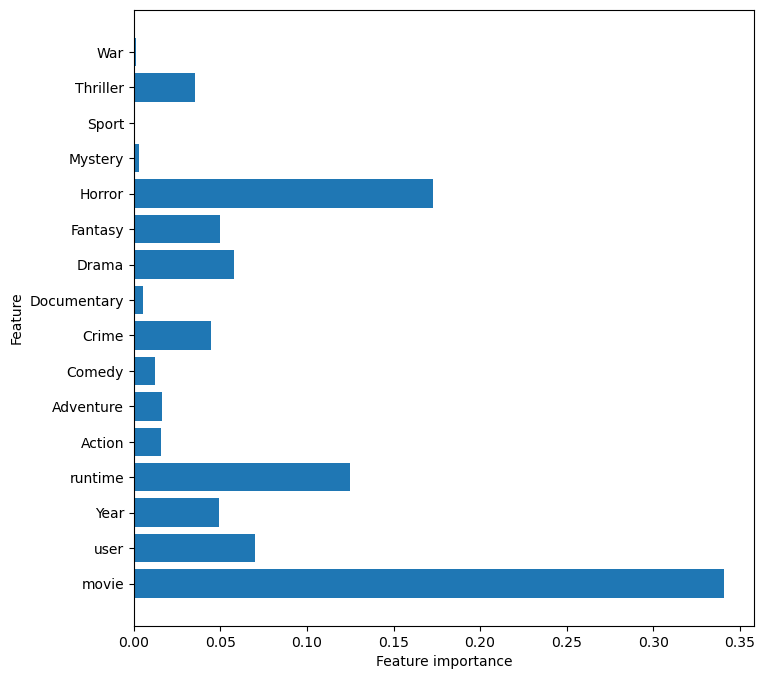

In [80]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest);

#### Observations
- Emsemble methods do not outperform the tuned decision tree
- The horror genre's prominence in feature importance could signify strong aversion to/ affinity of movies in the genre
- Runtime of the movie may also have a high impact on the ratings of the viewers

<hr>

### Clustering Users

A pivot table is created where every row is a user and every column is a different movie

In [81]:
user_ratings = ratings.pivot_table(index="user", columns="movie", values="category", fill_value=0)
user_ratings

movie,6,10,45,48,55,57,64,75,87,89,105,110,117,124,125,143
user,,,,,,,,,,,,,,,,
134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2649296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2649335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Genre information aggregated by user

In [82]:
genre_columns = mlb.classes_
genre_columns
#showing how many movies in certain genre a user has rated
user_genres = ratings.groupby("user")[genre_columns].sum()
user_genres

,Action,Adventure,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sport,Thriller,War
user,,,,,,,,,,,,
134,0,0,0,1,0,1,0,1,0,0,0,0
195,0,0,0,0,0,0,0,1,0,0,0,0
199,0,0,0,0,0,0,0,1,0,0,0,0
265,0,0,0,0,0,0,0,1,0,0,0,0
298,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2649267,0,0,0,0,0,0,0,1,0,0,0,0
2649296,0,1,0,0,1,0,0,1,0,0,0,0
2649335,0,0,0,0,0,0,0,1,0,0,0,0


The users' genre rating and individual movie ratings are combined

In [83]:
user_profile = user_ratings.join(user_genres).fillna(0)
user_profile

,6,10,45,48,55,57,64,75,87,89,...,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sport,Thriller,War
user,,,,,,,,,,,,,,,,,,,,,
134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,0,0,0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2649296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
2649335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


K Means clustering is performed to group together similar users

In [84]:
kmeans = KMeans(n_clusters=5)
user_profile.columns = user_profile.columns.astype(str)
cluster_labels = kmeans.fit_predict(user_profile)
# Adding cluster labels to the DataFrame
user_profile['cluster'] = cluster_labels

user_profile

/home/ian/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,6,10,45,48,55,57,64,75,87,89,...,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sport,Thriller,War,cluster
user,,,,,,,,,,,,,,,,,,,,,
134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2649296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,4
2649335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [85]:
user_profile.cluster.value_counts()

cluster
0    24593
2    10928
1     7677
3     3533
4     2414
Name: count, dtype: int64

A K Neighbours classifier will be used to classify future users into the defined clusters

In [86]:
X_cluster = user_profile.drop("cluster", axis=1)
y_cluster = user_profile.cluster
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, y_cluster, test_size=0.2)

cluster_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
cluster_pipe.fit(X_train_cluster, y_train_cluster)
print(f"{cluster_pipe.score(X_test_cluster, y_test_cluster) :.2%}")
y_pred_cluster = cluster_pipe.predict(X_test_cluster)
print(classification_report(y_test_cluster, y_pred_cluster))

99.43%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4891
           1       0.99      0.98      0.98      1531
           2       1.00      1.00      1.00      2220
           3       1.00      0.99      0.99       686
           4       0.97      0.99      0.98       501

    accuracy                           0.99      9829
   macro avg       0.99      0.99      0.99      9829
weighted avg       0.99      0.99      0.99      9829



#### Observations
- The model will be able to group newer users into the appropriate clusters accurately

## Recommendation System

With the clustering and user preference prediction created, the two systems are put together to create the recommendation algorithm.<hr>
Functions that help tesing of the models

In [87]:

cluster_df = DataFrameWrapper(user_profile)

In [88]:
#Pick a random user
def get_user():
    row = user_profile.sample(n=1)
    return row.drop("cluster", axis=1)
get_user()

,6,10,45,48,55,57,64,75,87,89,...,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sport,Thriller,War
user,,,,,,,,,,,,,,,,,,,,,
954415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0


In [93]:
#get a user's cluster using knn model
def get_cluster(user):
    return cluster_pipe.predict(user)[0]

get_cluster(get_user())

4

In [95]:
#A function that recommends movies for a specific cluster of users
def cluster_recommendations(cluster):
    cluster_data = cluster_df.column_search([
        ("cluster", cluster)
    ])
    # removing unused information
    to_drop = list(genre_columns)
    to_drop.append("cluster")
    #average rating of each movie in cluster
    average_ratings = cluster_data.drop(to_drop, axis=1).mean(axis=0)
    # Get top recommended movies
    recommended_movies = average_ratings.sort_values(ascending=False).head(10) 
    return recommended_movies
pd.DataFrame(cluster_recommendations(1))

,0
57,0.234076
110,0.068126
125,0.061873
55,0.060440
143,0.050801
6,0.046372
10,0.012114
117,0.010290
105,0.006904
75,0.004299


In [96]:
#get recommendations for a cluster
def get_user_recommendations(user):
    cluster = get_cluster(user)
    return cluster_recommendations(cluster)

In [97]:
#retrieve movie name from id
def get_movie_name(id):
    return movies[movies["ID"] == int(id)].title.iloc[0]
get_movie_name(48)

'Justice League'

In [98]:
#creates data for row to use in model testing
def get_movie_info(id, mlb):
    info_row = ratings[ratings.movie == int(id)]
    info = {
        "movie": id,
        "user": None,
        "Year": info_row.Year.iloc[0],
        "runtime": info_row.runtime.iloc[0],

    }
    #replicating one hot encoding
    for genre in mlb.classes_:
        info[genre] = info_row[genre].iloc[0]
    return info

In [99]:
#given a user and movie, the model predicts if it will be a good recommendation
def test_reccomendation(user, movie, predictor):
    test_row = get_movie_info(movie, mlb)
    test_row["user"] = user
    input_row = pd.DataFrame(test_row, index=[0])
    return predictor.predict(input_row)[0]

Putting it all together

In [104]:
user = get_user()
user_id = user.index[0]
print(f"User: {user_id}")
movie_rec = get_user_recommendations(user).index
recommended = []

for entry in movie_rec:
    #skip movie if watched before
    if len(ratings[(ratings.user == user_id) & (ratings.movie == entry)]) > 0:
        continue 
    else:
        if test_reccomendation(user_id, entry, bagged_tree) == 1:
            recommended.append(entry)
recommended_names = []
for entry in recommended:
    recommended_names.append(get_movie_name(entry))
print(f"Recommendations: {recommended_names}")

User: 1167032
Recommendations: ['Justice League', 'Richard III']


Viewing what movies the user has watched

In [106]:
ratings[(ratings.user == user_id)]

,movie,user,Year,runtime,category,Action,Adventure,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sport,Thriller,War
14482,89,1167032,2000,88.0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [107]:
for i in range(len(recommended)):
    prediction = test_reccomendation(user_id, recommended[i], bagged_tree)
    if prediction == 1:
        print(f"models predict user:{user_id} will like '{recommended_names[i]}'")
    else:
        print(f"models predict user:{user_id} will NOT like '{recommended_names[i]}'")

models predict user:1167032 will like 'Justice League'
models predict user:1167032 will like 'Richard III'


<hr>

## Evaluation

## Conclusion